## Define dataset

In [1]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

batch_size=100

transform=transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

cifar_path="../../Datasets/cifar10"
weight_path="../../Weights/Vgg19"

train=datasets.CIFAR10(root=cifar_path, download=True, train=True, transform=transform)


test=datasets.CIFAR10(root=cifar_path, download=True, train=False, transform=transform)
test_dl=DataLoader(test, batch_size=batch_size)
 
class_=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Train, Validation split

In [2]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

indices=list(range(len(train)))
values=[y for _,y in train]

s=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in s.split(indices, values):
    print(f"#train:{len(train_idx)}")
    print(f"#val:{len(val_idx)}")

c:\Users\wongyun\miniconda3\envs\torchstudy\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#train:40000
#val:10000


In [3]:
import collections
from torch.utils.data import Subset

val=Subset(train, val_idx)
train=Subset(train, train_idx)

val_count=collections.Counter([y for _, y in val])
train_count=collections.Counter([y for _, y in train])

print(f"train distribution:{train_count}")
print(f"validation distribution:{val_count}")

train distribution:Counter({6: 4000, 7: 4000, 8: 4000, 3: 4000, 2: 4000, 1: 4000, 4: 4000, 9: 4000, 0: 4000, 5: 4000})
validation distribution:Counter({2: 1000, 7: 1000, 1: 1000, 9: 1000, 6: 1000, 8: 1000, 0: 1000, 3: 1000, 5: 1000, 4: 1000})


In [4]:
train_dl=DataLoader(train, batch_size=batch_size)
val_dl=DataLoader(val, batch_size=batch_size)

### Define Model

In [5]:
import torch.nn as nn
# On thesis paper, initializion is done by weights with pretrained 11 layer net
# But they also mentioned  it is possible to initialize the weights without pre training by using "glorot et al 2010"

class VGG19(nn.Module):
  def __init__(self, initialization, num_classes=10):
    super(VGG19, self).__init__()

    self.initialization=initialization
    
    self.conv=nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(), #64, 32, 32
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #64, 16, 16

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(), #128, 16, 16
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), #128, 8, 8

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), #256, 4, 4

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),      
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),    
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),    
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), #512, 2, 2 

        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),      
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),    
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),    
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), #512, 1, 1 
    )
    
    self.classifier=nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(512, 1000),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(1000, 500),
        nn.ReLU(),
        nn.Linear(500, num_classes)
    )
    """
    for layer in self.modules(): #Use 4 normalization
          if isinstance(layer, (nn.Conv2d or nn.BatchNorm2d or nn.Linear)):
                  if initialization == "Xavier uniform":
                      nn.init.xavier_uniform_(layer.weight.data)
                  if initialization == "Xavier normal":
                      nn.init.xavier_normal_(layer.weight.data)
                  if initialization == "He uniform":
                      nn.init.kaiming_uniform_(layer.weight.data, mode='fan_in', nonlinearity='relu')
                  if initialization == "He normal":
                      nn.init.kaiming_normal_(layer.weight.data, mode='fan_in', nonlinearity='relu')
                  if initialization == "Normal":
                      nn.init.normal_(layer.weight.data, mean=0, std=0.01)  
    """                 
  def init_name(self):
    return self.initialization
                                    
  def forward(self, x):
    output=self.conv(x)
    output=output.view(-1, 512)
    output=self.classifier(output)
    return output


In [6]:
import torch
from torchsummary import summary

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model_xavier_uniform=VGG19("Xavier uniform").to(device)
model_xavier_normal=VGG19("Xavier normal").to(device)
model_he_uniform=VGG19("He uniform").to(device)
model_he_normal=VGG19("He normal").to(device)
model_normal=VGG19("Normal").to(device)

models=[model_xavier_uniform, model_xavier_normal, model_he_uniform, model_he_normal, model_normal]

print(summary(model_he_normal, input_size=(3,32, 32)))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-

In [8]:
import os

epoch=30
train_loss=[]
train_accuracy=[]
val_loss=[]
val_accuracy=[]
best_acc=0
best_loss=float('inf')



for model in models:
    for smoothing in np.arange(0, 0.4 ,0.15):
        print(f"🏀{model.init_name()}, Smoothing {smoothing}")

        for layer in model.modules(): #Use 4 normalization
            if isinstance(layer, (nn.Conv2d or nn.BatchNorm2d or nn.Linear)):
                if model.initialization == "Xavier uniform":
                    nn.init.xavier_uniform_(layer.weight.data)
                if model.initialization == "Xavier normal":
                    nn.init.xavier_normal_(layer.weight.data)
                if model.initialization == "He uniform":
                    nn.init.kaiming_uniform_(layer.weight.data, mode='fan_in', nonlinearity='relu')
                if model.initialization == "He normal":
                    nn.init.kaiming_normal_(layer.weight.data, mode='fan_in', nonlinearity='relu')
                if model.initialization == "Normal":
                    nn.init.normal_(layer.weight.data, mean=0, std=0.01)  
            
        
        
        loss_fn=nn.CrossEntropyLoss(label_smoothing=smoothing)
        optimizer=torch.optim.Adam(params=model.parameters())

        for iter in range(epoch):
            running_loss=0
            running_acc=0    

            model.train()
            for i, data in enumerate(train_dl):

                train_x, train_y= data
                train_x, train_y= train_x.to(device), train_y.to(device)
                optimizer.zero_grad()
                train_pred=model(train_x)
                loss=loss_fn(train_pred, train_y)

                _, predicted = torch.max(train_pred, 1) 
                acc = (predicted == train_y).squeeze().int() #boolean array
                acc = torch.sum(acc) #correct prediction

                loss.backward()
                optimizer.step()

                running_loss+=loss.item() #loss of each batch
                running_acc+=acc #

            print(f"epoch {iter+1}/{epoch} train loss: {running_loss/i} train acc: {running_acc/len(train)*100}%")
            #train loss divided by #batch
            #accuracy divided by #datasets
            train_loss.append(running_loss/i)
            train_accuracy.append(running_acc/len(train))

            running_loss=0
            running_acc=0

            model.eval()
            with torch.no_grad():
                for i, data in enumerate(val_dl):

                    val_x, val_y= data
                    val_x, val_y= val_x.to(device), val_y.to(device)

                    val_pred=model(val_x)
                    loss=loss_fn(val_pred, val_y)

                    _, predicted = torch.max(val_pred, 1)
                    acc = (predicted == val_y).squeeze().int()
                    acc = torch.sum(acc)

                    running_loss+=loss.item()
                    running_acc+=acc

            print(f"epoch {iter+1}/{epoch}, val loss: {running_loss/i} val acc: {running_acc/len(val)*100}%")
            val_loss.append(running_loss/i)
            val_accuracy.append(running_acc/len(val))

            
            if iter==9:
                model_10=model
                _10th_model_path=os.path.join(weight_path, (model.init_name()+"_"+str(iter)+"_"+str(smoothing)+"_"+'_10_epoch.pt'))
                torch.save(best_acc_model.state_dict(), _10th_model_path)  
            

            if (running_acc/len(val)) >= best_acc: #validation accuracy가 가장 큰 모델로 저장
                acc_model_path=os.path.join(weight_path, (model.init_name()+"_"+str(iter)+"_"+str(smoothing)+"_"+'vgg_acc.pt'))
                print("Best model acc😊")
                best_acc_model=model

                best_init_acc=model.init_name()
                best_acc=running_acc/len(val)

            if (running_loss/i)<best_loss:
                loss_model_path=os.path.join(weight_path, (model.init_name()+"_"+str(iter)+"_"+str(smoothing)+"_"+'vgg_loss.pt'))
                print("Best model loss😍")
                best_loss_model=model

                best_init_loss=model.init_name()
                best_loss=(running_loss/i)

            print("==============================================================")

torch.save(best_acc_model.state_dict(), acc_model_path)    
torch.save(best_loss_model.state_dict(), loss_model_path)

🏀Xavier uniform, Smoothing 0.0
epoch 1/30 train loss: 1.900204066345865 train acc: 24.954999923706055%
epoch 1/30, val loss: 1.8603717076657997 val acc: 28.470001220703125%
Best model acc😊
Best model loss😍
epoch 2/30 train loss: 1.6296645898866773 train acc: 35.82500076293945%
epoch 2/30, val loss: 1.5893260324844207 val acc: 39.18000030517578%
Best model acc😊
Best model loss😍
epoch 3/30 train loss: 1.3925164973825441 train acc: 46.54750061035156%
epoch 3/30, val loss: 1.7839758095115121 val acc: 40.95000076293945%
Best model acc😊
epoch 4/30 train loss: 1.169290568744927 train acc: 57.82749557495117%
epoch 4/30, val loss: 1.1565726700455252 val acc: 58.88999557495117%
Best model acc😊
Best model loss😍
epoch 5/30 train loss: 1.003591947836386 train acc: 65.19000244140625%
epoch 5/30, val loss: 1.0935770213001905 val acc: 61.97999572753906%
Best model acc😊
Best model loss😍
epoch 6/30 train loss: 0.885342428259981 train acc: 70.07249450683594%
epoch 6/30, val loss: 0.8580892706158185 val a

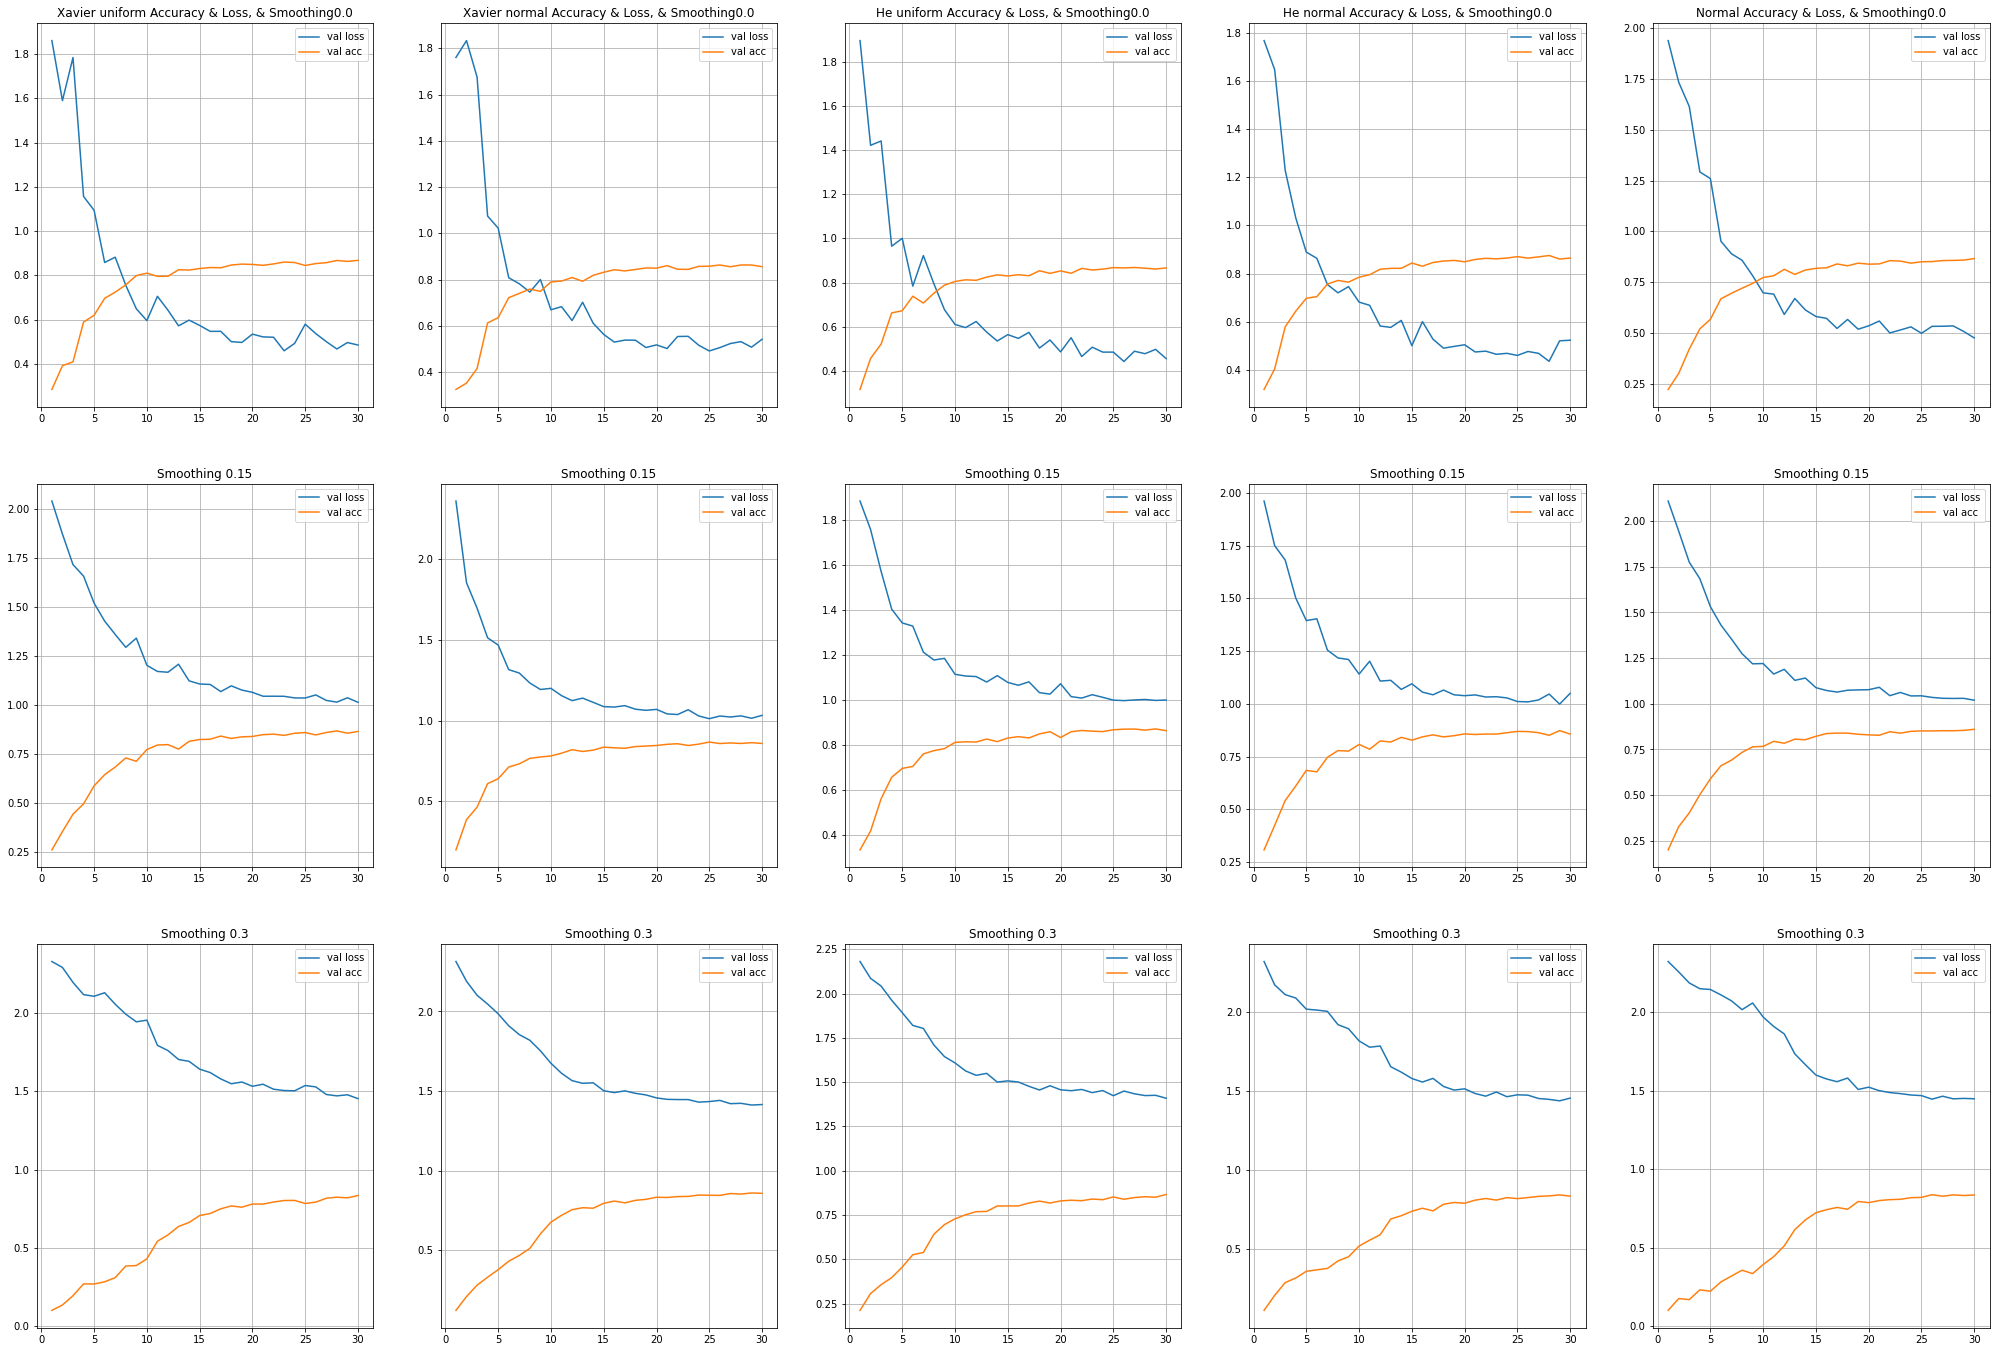

In [23]:
import matplotlib.pyplot as plt

train_acc=[x.item() for x in train_accuracy]
val_acc=[x.item() for x in val_accuracy]


plt.figure(figsize=(35, 24))
for i, model in enumerate(models):
    for j in range(3):
        plt.subplot(3, len(models), (i+1)+len(models)*(j))
        plt.plot(np.arange(1,epoch+1), train_loss[j*epoch+(i*3*epoch):(j+1)*epoch+(i*3*epoch)], label="train loss")
        plt.plot(np.arange(1,epoch+1), val_loss[j*epoch+(i*3*epoch):(j+1)*epoch+(i*3*epoch)], label="val loss")
        plt.grid(True)
        plt.plot(np.arange(1,epoch+1), train_acc[j*epoch+(i*3*epoch):(j+1)*epoch+(i*3*epoch)], label="train acc")
        plt.plot(np.arange(1,epoch+1), val_acc[j*epoch+(i*3*epoch):(j+1)*epoch+(i*3*epoch)], label="val acc")
        if j==0:
            plt.title(f"{model.init_name()} Accuracy & Loss, & Smoothing{j*0.1}")
        else:
            plt.title(f"Smoothing {j*0.15}")
        plt.grid(True)
        plt.legend()
    
plt.show()    

#Smoothing 이 있을 때 accuracy가 최대인 점과 Loss가 최소인 점이 유사해야함
#Smoothing 이 있을 때 train이 좀 덜 되어야함

# 비교하고자 하는건 각 initialization에서 train, val 차이
# 같은 initialization 일 때 smoothing의 영향

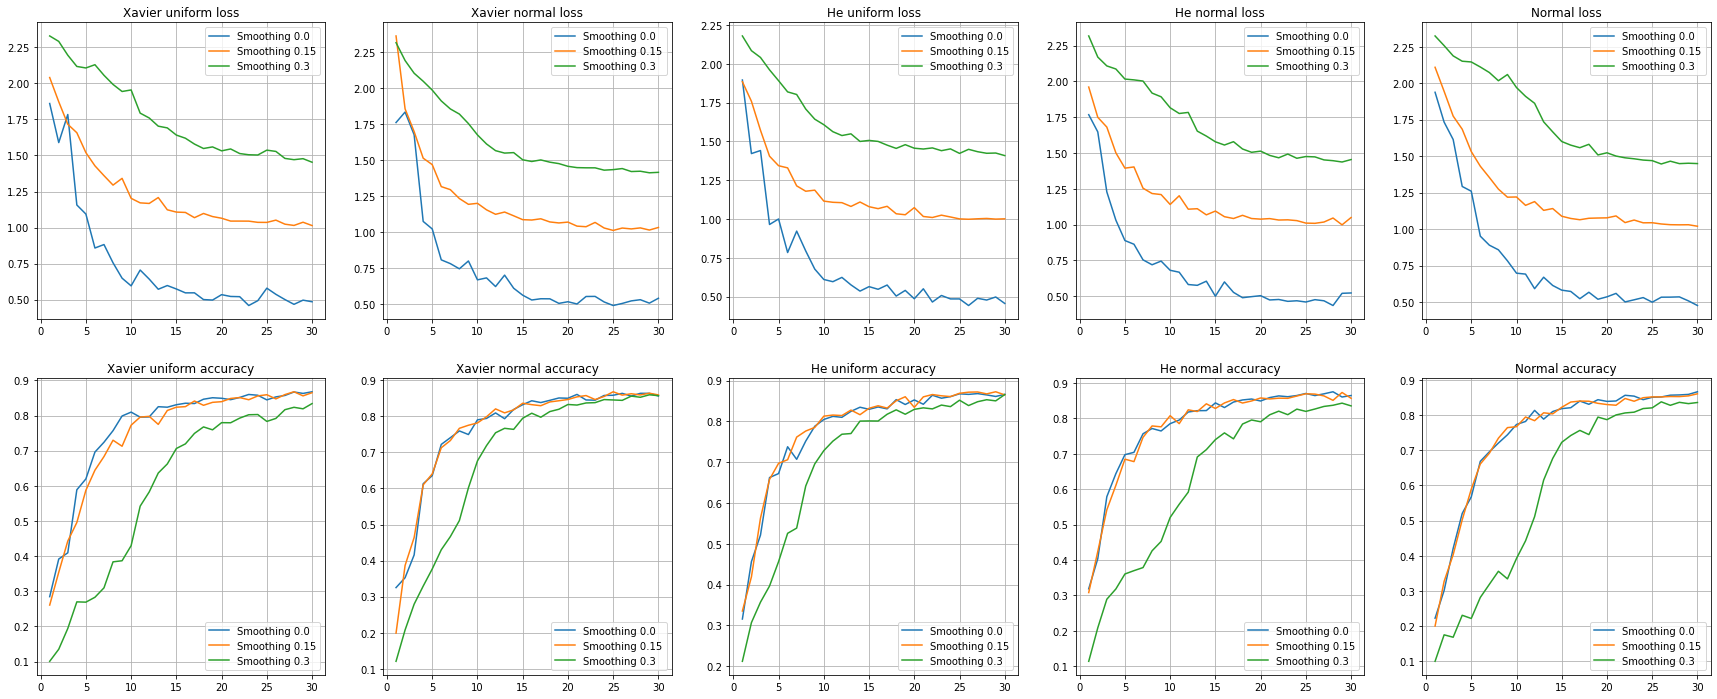

In [17]:
#validation set 기준 학습이 얼마나 잘 되는지: 같은 initialization일 때 validation loss와 validation accuracy 비교하기 
#loss와 accuracy 각각, initialization이 5개니까 총 10개 그래프 그리기
plt.figure(figsize=(30,12))

for i, model in enumerate(models):
    plt.subplot(2, len(models), i+1)
    for j in range(3):
        plt.plot(np.arange(1, epoch+1),val_loss[j*epoch+(i*3*epoch):(j+1)*epoch+(i*3*epoch)] ,label= (f"Smoothing {j*0.15}"))
        plt.grid(True)
        plt.legend()
        plt.title(f"{model.init_name()} loss")
        
    plt.subplot(2, len(models), i+1+len(models))
    for j in range(3):
        plt.plot(np.arange(1, epoch+1),val_acc[j*epoch+(i*3*epoch):(j+1)*epoch+(i*3*epoch)] ,label= (f"Smoothing {j*0.15}"))
        plt.grid(True)
        plt.legend()
        plt.title(f"{model.init_name()} accuracy")     
          
plt.show()         

In [18]:
print(acc_model_path)
print(loss_model_path)

../../Weights/Vgg19\He normal_27_0.0_vgg_acc.pt
../../Weights/Vgg19\He normal_27_0.0_vgg_loss.pt


In [19]:
model_best_acc=VGG19(best_init_acc).to(device) 
model_state_dict=torch.load(acc_model_path, map_location=device)
model_best_acc.load_state_dict(model_state_dict)

model_best_loss=VGG19(best_init_loss).to(device)
model_state_dict=torch.load(loss_model_path, map_location=device)
model_best_loss.load_state_dict(model_state_dict)

<All keys matched successfully>

### Best Accuracy test

In [20]:
print(acc_model_path)

running_loss=0
running_acc=0

model_best_loss.eval()
with torch.no_grad():
    for i, data in enumerate(test_dl): 
        test_x, test_y= data
        test_x, test_y= test_x.to(device), test_y.to(device)
        
        test_pred=model_best_loss(test_x)
        loss=loss_fn(test_pred, test_y)
        _, predicted = torch.max(test_pred, 1)
        acc = (predicted == test_y).squeeze().int()
        acc = torch.sum(acc)
        
        running_loss+=loss.item()
        running_acc+=acc
        
    print(f"test loss: {running_loss/i}, test accuracy: {running_acc/len(test)*100}%")

../../Weights/Vgg19\He normal_27_0.0_vgg_acc.pt
test loss: 1.4646798275937938, test accuracy: 82.70999908447266%


### Best Loss test

In [21]:
print(loss_model_path)

running_loss=0
running_acc=0

model_best_acc.eval()
with torch.no_grad():
    for i, data in enumerate(test_dl): 
        test_x, test_y= data
        test_x, test_y= test_x.to(device), test_y.to(device)
        
        test_pred=model_best_acc(test_x)
        loss=loss_fn(test_pred, test_y)
        _, predicted = torch.max(test_pred, 1)
        acc = (predicted == test_y).squeeze().int()
        acc = torch.sum(acc)
        
        running_loss+=loss.item()
        running_acc+=acc
        
    print(f"test loss: {running_loss/i}, test accuracy: {running_acc/len(test)*100}%")

../../Weights/Vgg19\He normal_27_0.0_vgg_loss.pt
test loss: 1.4706568272426874, test accuracy: 82.66999816894531%
